# InSDN Dataset - Network Intrusion Detection

This notebook trains a deep neural network to detect network intrusions using the InSDN Dataset.

## Features:
- Automatic dataset download
- Feature selection (25 most important features)
- Deep neural network training
- Comprehensive evaluation and visualization


In [1]:
import os, sys

# Must run before importing tensorflow in this runtime
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # reduce TF logs
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Uncomment to force CPU-only

if "tensorflow" in sys.modules:
    print("WARNING: TensorFlow was already imported. Use 'Restart Session' and run Cell 0 first.")

import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

import pandas as pd
import numpy as np
from feature_selection import feature_selection_pipeline


TensorFlow: 2.20.0
GPUs: []


## Step 1: Load Dataset

Auto-downloads the InSDN dataset from Kaggle if not present locally.


In [2]:
# Auto-download dataset if not present
data_dir = "./data/InSDN_DatasetCSV"
if not os.path.exists(data_dir):
    print("Dataset not found locally. Downloading from Kaggle...")
    try:
        import kagglehub
        import shutil
        
        # Download dataset using kagglehub
        downloaded_path = kagglehub.dataset_download("badcodebuilder/insdn-dataset")
        source_path = os.path.join(downloaded_path, "InSDN_DatasetCSV")
        
        # Copy to local data directory
        os.makedirs("./data", exist_ok=True)
        shutil.copytree(source_path, data_dir)
        print(f"Dataset downloaded and copied to {data_dir}")
    except ImportError:
        print("ERROR: kagglehub not installed. Install with: pip install kagglehub")
        print("Or manually download the dataset from: https://www.kaggle.com/datasets/badcodebuilder/insdn-dataset")
        sys.exit(1)
    except Exception as e:
        print(f"ERROR downloading dataset: {e}")
        print("Please manually download from: https://www.kaggle.com/datasets/badcodebuilder/insdn-dataset")
        sys.exit(1)
else:
    print(f"Dataset found at {data_dir}")

paths = {
    "normal": "./data/InSDN_DatasetCSV/Normal_data.csv",
    "ovs": "./data/InSDN_DatasetCSV/OVS.csv",
    "metasploitable": "./data/InSDN_DatasetCSV/metasploitable-2.csv",
}

dfs = []
for src, p in paths.items():
    d = pd.read_csv(p, low_memory=False)
    d["__source__"] = src
    dfs.append(d)

df = pd.concat(dfs, ignore_index=True)
print("df shape:", df.shape)
df.head()


Dataset found at ./data/InSDN_DatasetCSV
df shape: (343889, 85)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,__source__
0,185.127.17.56-192.168.20.133-443-53648-6,185.127.17.56,443,192.168.20.133,53648,6,5/2/2020 13:58,245230,44,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,normal
1,185.127.17.56-192.168.20.133-443-53650-6,192.168.20.133,53650,185.127.17.56,443,6,5/2/2020 13:58,1605449,107,149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,normal
2,192.168.20.133-192.168.20.2-35108-53-6,192.168.20.133,35108,192.168.20.2,53,6,5/2/2020 13:58,53078,5,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,normal
3,192.168.20.133-192.168.20.2-35108-53-6,192.168.20.2,53,192.168.20.133,35108,6,5/2/2020 13:58,6975,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,normal
4,154.59.122.74-192.168.20.133-443-60900-6,192.168.20.133,60900,154.59.122.74,443,6,5/2/2020 13:58,190141,13,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,normal


## Step 2: Data Preprocessing

Clean data and create binary labels (Normal vs Attack).


In [3]:
# basic cleanup
df = df.replace([np.inf, -np.inf], np.nan).drop_duplicates()

# we know the label column name from the schema
BASE_LABEL_COL = "Label"
LABEL_COL = "LabelBinary"

# collapse to binary: Normal/Benign -> Normal, everything else -> Attack
s = df[BASE_LABEL_COL].astype(str).str.strip().str.lower()

df[LABEL_COL] = np.where(
    s.isin({"normal", "benign", "0"}) | s.str.contains("normal") | s.str.contains("benign"),
    "Normal",
    "Attack"
)

print(df[LABEL_COL].value_counts())

# use the binary label we just created; change to "Label" if we want multi-class later
LABEL_COL = "LabelBinary"
y = df[LABEL_COL]


LabelBinary
Attack    275465
Normal     68423
Name: count, dtype: int64


## Step 3: Feature Selection

Apply three-tier feature selection to reduce from 67 to 25 most important features.


In [4]:
# ============================================================
# FEATURE SELECTION PIPELINE
# ============================================================
print("\n" + "=" * 60)
print("APPLYING FEATURE SELECTION")
print("=" * 60)

X, feature_scores, selection_summary = feature_selection_pipeline(
    df, y,
    variance_threshold=0.01,        # Remove very low variance features
    missing_threshold=0.5,         # Remove features with >50% missing
    correlation_threshold=0.90,    # Remove highly correlated (stricter for overfitting)
    n_features=25,                 # Keep top 25 features
    method='mutual_info',          # Use mutual information (good for non-linear)
    random_state=42,
    verbose=True
)

# Save feature selection results
os.makedirs("./output", exist_ok=True)
feature_scores.to_csv('./output/feature_selection_scores.csv', index=False)
print(f"\nSaved feature selection scores to ./output/feature_selection_scores.csv")

print("Remaining X shape:", X.shape)



APPLYING FEATURE SELECTION
FEATURE SELECTION PIPELINE
Starting with 86 columns

Tier 1: Dropped 19 columns
  - Identifiers/targets: 7
  - Constant columns: 12
Tier 2a: Variance filter - 66 features remain (1 dropped)
Tier 2b: Missing data filter - 66 features remain (0 dropped)
Tier 2c: Correlation filter - 39 features remain (27 dropped)
Tier 3: Selected 25 features using Mutual Information

Top 10 features by score:
         feature    score
  Fwd Header Len 0.424739
  Bwd Header Len 0.423624
        Dst Port 0.411435
     Pkt Len Max 0.382585
     Pkt Len Std 0.369308
     Pkt Len Var 0.369252
Subflow Bwd Byts 0.342714
    Tot Fwd Pkts 0.313029
 Bwd Pkt Len Std 0.307161
 Fwd Pkt Len Max 0.301683

FEATURE SELECTION SUMMARY
Original features:     86
After Tier 1:          67
After Tier 2:          39
Final selected:        25
Total reduction:       61 (70.9%)

Saved feature selection scores to ./output/feature_selection_scores.csv
Remaining X shape: (343888, 25)


## Step 4: Prepare Data for Training

Split data and create preprocessing pipeline.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Train/test split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42
)

# Column types
cat_cols = X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X_train_raw.columns if c not in cat_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Handle both sklearn versions: sparse_output (new) vs sparse (old)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
)

# Fit on train only (no leakage)
X_train = preprocess.fit_transform(X_train_raw).astype("float32")
X_test  = preprocess.transform(X_test_raw).astype("float32")
                                                                                                                      
# Label encode
le = LabelEncoder()
y_train_int = le.fit_transform(y_train_raw)
y_test_int  = le.transform(y_test_raw)

num_classes = len(le.classes_)
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("Classes:", list(le.classes_))

# Class weights (helps if imbalanced)
classes = np.unique(y_train_int)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_int)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
print("class_weight:", class_weight)


X_train: (275110, 25) X_test: (68778, 25)
Classes: ['Attack', 'Normal']
class_weight: {0: 0.624194543771441, 1: 2.512970879462165}


## Step 5: Build Neural Network Model


In [6]:
from tensorflow import keras
from tensorflow.keras import layers

# Binary vs multiclass head
if num_classes <= 2:
    y_train_nn = y_train_int.astype("float32")
    y_test_nn  = y_test_int.astype("float32")
    output_units = 1
    output_activation = "sigmoid"
    loss = "binary_crossentropy"
else:
    y_train_nn = keras.utils.to_categorical(y_train_int, num_classes)
    y_test_nn  = keras.utils.to_categorical(y_test_int, num_classes)
    output_units = num_classes
    output_activation = "softmax"
    loss = "categorical_crossentropy"

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(output_units, activation=output_activation),
])

opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,377 (271.00 KB)

 Trainable params: 69,377 (271.00 KB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Train Model


In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./output/best_model.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=3,
        restore_best_weights=True,
        verbose=1,
    ),
]

history = model.fit(
    X_train, y_train_nn,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    class_weight=class_weight if num_classes <= 2 else None,  # class_weight expects integer labels
    callbacks=callbacks,
    verbose=1,
)


Epoch 1/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9399 - loss: 0.1664
Epoch 1: val_accuracy improved from None to 0.99560, saving model to ./output/best_model.keras
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9800 - loss: 0.0703 - val_accuracy: 0.9956 - val_loss: 0.0181
Epoch 2/30
1719/1720 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0274
Epoch 2: val_accuracy improved from 0.99560 to 0.99637, saving model to ./output/best_model.keras
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9946 - loss: 0.0264 - val_accuracy: 0.9964 - val_loss: 0.0171
Epoch 3/30
1705/1720 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9948 - loss: 0.0252
Epoch 3: val_accuracy improved from 0.99637 to 0.99691, saving model to ./output/best_model.keras
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9952 - loss: 0.0236 - val_accuracy: 0.9969 - val_loss: 0.0119
Epoch 4/30
1706/1720 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9958 - loss: 0.0212


## Step 7: Evaluate Model


In [8]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate
test_metrics = model.evaluate(X_test, y_test_nn, verbose=0)
print(dict(zip(model.metrics_names, test_metrics)))

# Predictions + report
if num_classes <= 2:
    y_prob = model.predict(X_test, verbose=0).reshape(-1)
    y_pred = (y_prob >= 0.5).astype(int)
    y_true = y_test_int
else:
    y_prob = model.predict(X_test, verbose=0)
    y_pred = y_prob.argmax(axis=1)
    y_true = y_test_int

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=[str(c) for c in le.classes_]))

# Save model + preprocess + label encoder
os.makedirs("./output", exist_ok=True)
model.save("./output/final_model.keras")
joblib.dump(preprocess, "./output/preprocess.joblib")
joblib.dump(le, "./output/label_encoder.joblib")

print("Saved to ./output: final_model.keras, preprocess.joblib, label_encoder.joblib")


{'loss': 0.003986877389252186, 'compile_metrics': 0.9994329810142517}
Confusion matrix:
 [[55079    14]
 [   25 13660]]
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00     55093
      Normal       1.00      1.00      1.00     13685

    accuracy                           1.00     68778
   macro avg       1.00      1.00      1.00     68778
weighted avg       1.00      1.00      1.00     68778

Saved to ./output: final_model.keras, preprocess.joblib, label_encoder.joblib


## Step 8: Visualize Training Curves


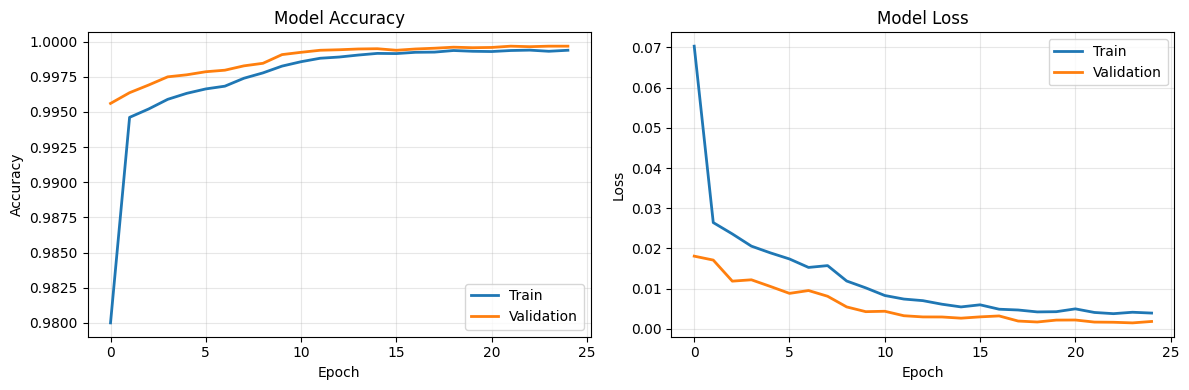

Saved training curves to ./output/training_curves.png


In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./output/training_curves.png', dpi=150)
plt.show()
print("Saved training curves to ./output/training_curves.png")


## Step 9: Feature Importance Analysis

Calculate permutation importance to identify the most critical features.


In [10]:
from sklearn.inspection import permutation_importance

print("\nCalculating feature importance (this may take a few minutes)...")

# Get feature names from preprocessor
feature_names = []
# Numeric features
feature_names.extend(num_cols)
# Categorical features (one-hot encoded names)
if cat_cols:
    ohe_feature_names = preprocess.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
    feature_names.extend(ohe_feature_names)

# Adjust feature names to match actual transformed features
actual_features = X_test.shape[1]
if len(feature_names) > actual_features:
    feature_names = feature_names[:actual_features]
elif len(feature_names) < actual_features:
    feature_names.extend([f'feature_{i}' for i in range(len(feature_names), actual_features)])

# Create a wrapper for sklearn's permutation_importance
class KerasClassifierWrapper:
    def __init__(self, model, threshold=0.5):
        self.model = model
        self.threshold = threshold
        self.classes_ = np.array([0, 1])
    
    def fit(self, X, y):
        return self  # Already trained
    
    def predict(self, X):
        probs = self.model.predict(X, verbose=0)
        if len(probs.shape) == 1 or probs.shape[1] == 1:
            return (probs.reshape(-1) >= self.threshold).astype(int)
        return probs.argmax(axis=1)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return (y_pred == y).mean()

wrapper = KerasClassifierWrapper(model)

# Calculate permutation importance on a subset for speed
sample_size = min(5000, len(X_test))
indices = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[indices]
y_sample = y_test_int[indices]

result = permutation_importance(
    wrapper, X_sample, y_sample, 
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)

# Get top 20 most important features
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': result.importances_mean,
    'std': result.importances_std
}).sort_values('importance', ascending=False)

print("\n=== TOP 20 MOST IMPORTANT FEATURES ===")
print(importance_df.head(20).to_string(index=False))

# Save feature importance
importance_df.to_csv('./output/feature_importance.csv', index=False)
print("\nSaved feature importance to ./output/feature_importance.csv")



Calculating feature importance (this may take a few minutes)...

=== TOP 20 MOST IMPORTANT FEATURES ===
          feature  importance      std
Init Bwd Win Byts     0.10508 0.001545
  Bwd Pkt Len Min     0.03078 0.001244
         Protocol     0.02244 0.001903
    Flow Duration     0.01456 0.001455
         Dst Port     0.01032 0.000475
   Fwd Header Len     0.00972 0.000835
      Pkt Len Std     0.00894 0.001456
   Bwd Header Len     0.00760 0.000800
      Fwd IAT Max     0.00758 0.000724
    Down/Up Ratio     0.00722 0.000961
      Flow Pkts/s     0.00600 0.000420
  Fwd Pkt Len Max     0.00554 0.000764
  Fwd Pkt Len Min     0.00424 0.000828
      Pkt Len Max     0.00300 0.000482
         Src Port     0.00202 0.000394
Fwd Act Data Pkts     0.00178 0.000374
     Flow IAT Min     0.00126 0.000180
  Bwd Pkt Len Std     0.00124 0.000445
      Flow Byts/s     0.00104 0.000377
      Pkt Len Var     0.00084 0.000294

Saved feature importance to ./output/feature_importance.csv


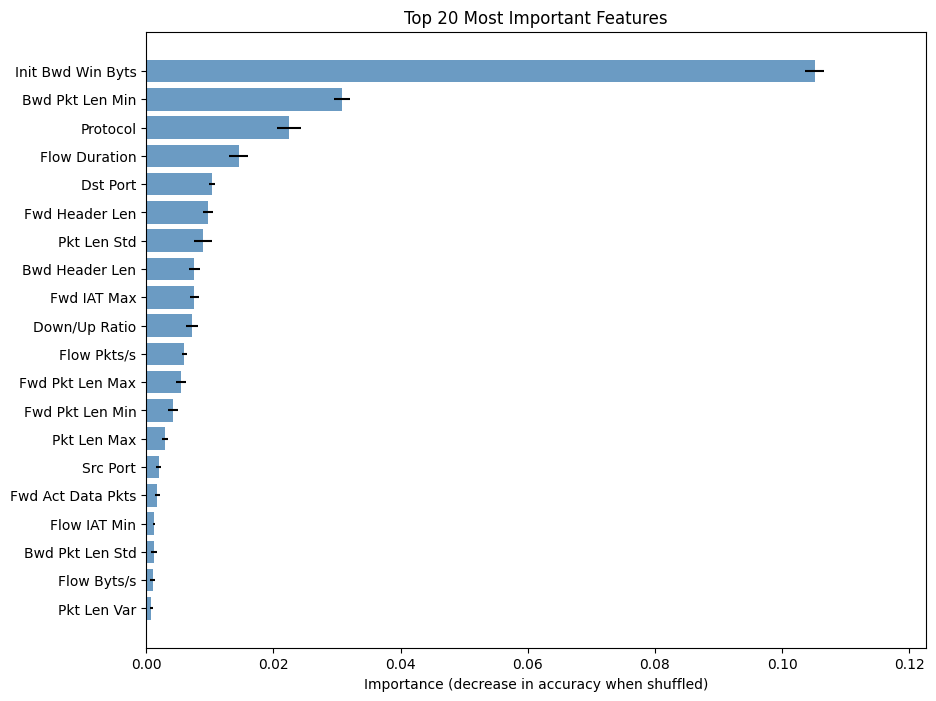

Saved feature importance plot to ./output/feature_importance.png


In [11]:
# Plot top 20 features
top_n = 20
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(top_n), top_features['importance'].values[::-1], 
        xerr=top_features['std'].values[::-1], alpha=0.8, color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values[::-1])
ax.set_xlabel('Importance (decrease in accuracy when shuffled)')
ax.set_title('Top 20 Most Important Features')

# Add padding to x-axis so bars and error bars don't extend beyond the border
max_val = (top_features['importance'] + top_features['std']).max()
ax.set_xlim(0, max_val * 1.15)  # 15% padding on the right

plt.subplots_adjust(left=0.25)  # Add more space on the left for feature labels
plt.savefig('./output/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved feature importance plot to ./output/feature_importance.png")
